평가문항	상세기준
1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.	


    텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.


2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.	


    학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.


3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.	


    샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.



keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다. 

이를 위해서 keras-ocr을 설치해주고 Detector를 만들어주세요.

In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train/'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train/


In [34]:
import numpy as np
import keras_ocr
from PIL import Image, ImageDraw

# keras-ocr의 Detector 인스턴스 생성 (최초 실행 시 모델 다운로드 진행)
detector = keras_ocr.detection.Detector()

def detect_text(img_input):
    """
    이미지 내에서 텍스트 영역을 검출하는 함수.
    img_input이 파일 경로(str)라면 로드하고, PIL 이미지 객체라면 그대로 사용.
    """
    # 1. 파일 경로인지 확인하고, 아니라면 PIL 이미지로 처리
    if isinstance(img_input, str):  # 파일 경로(str)인 경우
        img_pil = Image.open(img_input).convert("RGB")
    elif isinstance(img_input, Image.Image):  # PIL 이미지인 경우
        img_pil = img_input
    else:
        raise ValueError("img_input must be a file path (str) or a PIL.Image object")

    # 2. numpy array로 변환 (H, W, C) 및 배치 차원 확장 (리스트로 감싸줌)
    img = np.array(img_pil)
    img_batch = [img]  # 배치 처리를 위한 리스트 형태

    # 3. keras-ocr 입력 차원에 맞게 inference 진행
    ocr_results = detector.detect(img_batch)
    ocr_result = ocr_results[0]  # 배치의 첫 번째 결과 사용

    # 4. 결과 시각화를 위해 이미지 복사 및 drawing 객체 생성
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)
    
    cropped_imgs = []
    for text_result in ocr_result:
        polygon = [tuple(point) for point in text_result]
        img_draw.polygon(polygon, outline='red')
        
        # 텍스트 영역 좌표 추출 5 -> 10으로 늘리기
        
        x_min = int(text_result[:, 0].min() - 10)
        x_max = int(text_result[:, 0].max() + 10)
        y_min = int(text_result[:, 1].min() - 10)
        y_max = int(text_result[:, 1].max() + 10)
        word_box = (x_min, y_min, x_max, y_max)
        
        # 텍스트 영역 잘라내기
        cropped_imgs.append(img_pil.crop(word_box))
    
    return result_img, cropped_imgs



Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


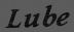

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


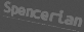

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


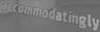

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


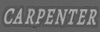

In [3]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [4]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [5]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [7]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

In [8]:
label_converter = LabelConverter(TARGET_CHARACTERS)

In [9]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [10]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [11]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# ModelCheckpoint: val_loss 모니터링, weight만 저장, 가장 좋은 모델만 저장하도록 설정
ckp = ModelCheckpoint(filepath=checkpoint_path, 
                      monitor='val_loss', 
                      save_weights_only=True, 
                      save_best_only=True, 
                      verbose=1)

# EarlyStopping: val_loss 모니터링, patience(개선이 없을 때 기다릴 epoch 수)를 5로 설정
earlystop = EarlyStopping(monitor='val_loss', 
                          patience=5, 
                          verbose=1)

# 모델 학습 시, callbacks 인자에 위에서 정의한 콜백들을 전달합니다.
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])


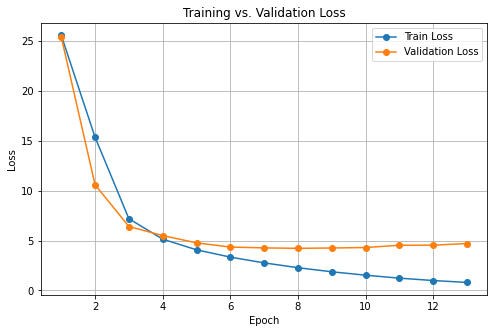

In [12]:
import matplotlib.pyplot as plt

# 수동으로 입력한 에포크별 loss 값 (Epoch 1 ~ Epoch 13)
epochs = list(range(1, 14))
train_loss = [25.5302, 15.3391, 7.1827, 5.1342, 4.0692, 3.3379, 2.7610, 2.2785, 1.8694, 1.5295, 1.2314, 0.9955, 0.8031]
val_loss = [25.3794, 10.5830, 6.4008, 5.4947, 4.7635, 4.3464, 4.2596, 4.2169, 4.2510, 4.2974, 4.5248, 4.5332, 4.6973]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


validation 값이 가장 높은 epoch로 설정 earlystopping으로 13에서 멈췄음

In [13]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING


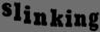

Result: 	 ALEPPO


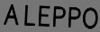

Result: 	 FWANDA


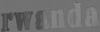

Result: 	 NATHANS


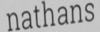

Result: 	 HALLE


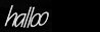

Result: 	 HURLS


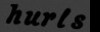

Result: 	 DOWNSIZE


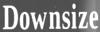

Result: 	 ROBOTIC


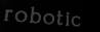

Result: 	 SLOPPY


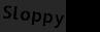

Result: 	 SHERMITE


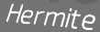

In [14]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(y_pred, chars):
    """
    CTC 디코딩을 수행하는 함수
    - y_pred: (batch, time_steps, num_classes) 형태의 모델 출력
    - chars : 문자 집합, blank('-') 포함
    """
    decoded, _ = K.ctc_decode(
        y_pred, 
        input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1],
        greedy=True
    )
    
    decoded_indices = K.get_value(decoded[0])  # (batch, decoded_length)

    results = []
    for seq in decoded_indices:
        text = ""
        prev_idx = -1  # 이전 인덱스를 추적하여 중복 제거
        for idx in seq:
            if idx != prev_idx and idx > 0:  # 0(blank) 제외, 중복 문자 제거
                text += chars[idx]
            prev_idx = idx  # 이전 인덱스 업데이트
        results.append(text)

    return results


# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index=5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1, :, :, :]
        output = model.predict(img)
        
        # 변경된 CTC 디코딩 적용
        result = decode_predict_ctc(output, chars="-" + TARGET_CHARACTERS)[0]
        
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1, 0, 2).astype(np.uint8)))


check_inference(model_pred, test_set, index=10)

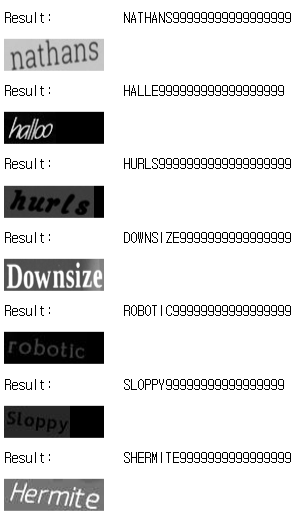

출력 결과물에서 99999로 나타나는 오류(?) 발생.

CTC 디코딩 부분에서 Blank 쪽이 잘못 된 것 같습니다.

Greedy 디코딩 활성화하고  CTC blank (인덱스 0) 무시하는 방향으로 일단 수정하였습니다.

greedy 를 했을 때 발생하는 문제점 생각, blank를 무시하면 어떤게 문제가 생기는 지 나중에 봐야함.



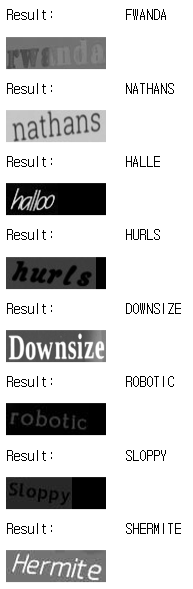

In [19]:
import numpy as np
from PIL import Image

def recognize_img(pil_img, model, chars, input_img_size=(100, 32)):
    """
    OCR 모델을 이용하여 단어 이미지를 예측하는 함수 (가로/세로 변환 문제 수정)
    """
    # 1. 이미지 크기를 OCR 모델이 기대하는 (100, 32)로 변환
    resized_img = pil_img.resize(input_img_size, Image.ANTIALIAS)  # (100, 32)

    # 2. numpy 배열 변환 및 정규화 (0~1)
    img_array = np.array(resized_img).astype(np.float32) / 255.0

    # 3. **흑백 이미지 → RGB 변환**
    if len(img_array.shape) == 2:  # 흑백 이미지라면
        img_array = np.expand_dims(img_array, axis=-1)  # (100, 32, 1)
        img_array = np.repeat(img_array, 3, axis=-1)  # (100, 32, 3)

    # 4. **채널 순서 확인 및 배치 차원 추가**
    img_array = np.expand_dims(img_array, axis=0)  # (1, H, W, C)

    if img_array.shape[1] != 100:  # 높이가 100이 아니라면 변환 필요
        img_array = np.transpose(img_array, (0, 2, 1, 3))  # (1, 32, 100, 3) → (1, 100, 32, 3)

    print(f"✅ Model Input Shape (Fixed): {img_array.shape}")

    # 5. **OCR 모델 예측 수행**
    y_pred = model.predict(img_array)

    # 6. **CTC 디코딩 수행**
    decoded_text = decode_predict_ctc(y_pred, chars="-" + chars)[0]

    return decoded_text








In [43]:
lmdb_path = TEST_DATA_PATH  # LMDB 경로

# LMDB 열기
env = lmdb.open(lmdb_path, readonly=True, lock=False, readahead=False, meminit=False)

with env.begin(write=False) as txn:
    n_samples = int(txn.get('num-samples'.encode()))
    print(f"Total samples in LMDB: {n_samples}")

    index = 9
    img_key = f'image-{index:09d}'.encode()
    imgbuf = txn.get(img_key)

    if imgbuf:
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        img_pil = Image.open(buf).convert('RGB')  # PIL 이미지 변환

        # detect_text() 실행
        result_img, cropped_imgs = detect_text(img_pil)

        # 결과 출력
        display(result_img)

        # 단어 인식 수행
        for cropped_img in cropped_imgs:
            recognized_text = recognize_img(cropped_img, model_pred, TARGET_CHARACTERS)
            print("Recognized Text:", recognized_text)
    else:
        print(f"No image found for index {index}")


Total samples in LMDB: 891924


✅ Model Input Shape (Fixed): (1, 100, 32, 3)
Recognized Text: EY


Word 1:


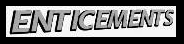

✅ Model Input Shape (Fixed): (1, 100, 32, 3)
Recognized Text: EY


In [44]:
# detect_text() 실행
result_img, cropped_imgs = detect_text(img_pil)

# 결과 출력
display(result_img)

# 단어 인식 수행 전에 이미지 확인
for i, cropped_img in enumerate(cropped_imgs):
    print(f"Word {i+1}:")
    display(cropped_img)  # **OCR 수행 전에 이미지 출력**
    
    recognized_text = recognize_img(cropped_img, model_pred, TARGET_CHARACTERS)
    print("Recognized Text:", recognized_text)


In [45]:
for i, cropped_img in enumerate(cropped_imgs):
    img_array = np.array(cropped_img.resize((100, 32))).astype(np.float32) / 255.0

    if len(img_array.shape) == 2:
        img_array = np.expand_dims(img_array, axis=-1)  # (H, W, 1)
        img_array = np.repeat(img_array, 3, axis=-1)  # (H, W, 3)

    # 🔹 채널 차원 확인 및 변환
    img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가 (1, H, W, C)

    #  **H, W 위치 변환 (32, 100, 3) → (100, 32, 3)**
    img_array = np.transpose(img_array, (0, 2, 1, 3))  # (1, 32, 100, 3) → (1, 100, 32, 3)

    # 수정 후 입력 크기 확인
    print(f"✅ Model Input Shape (Fixed): {img_array.shape}")

    # 🔹 OCR 모델 예측
    y_pred = model_pred.predict(img_array)

    # 🔹 원본 OCR 출력 확인
    print(f"Word {i+1}: Raw OCR Output (argmax) →", np.argmax(y_pred, axis=-1))

    recognized_text = recognize_img(cropped_img, model_pred, TARGET_CHARACTERS)
    print("Recognized Text:", recognized_text)


✅ Model Input Shape (Fixed): (1, 100, 32, 3)
Word 1: Raw OCR Output (argmax) → [[37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37  5 25]]
✅ Model Input Shape (Fixed): (1, 100, 32, 3)
Recognized Text: EY


# 에러

Model Input Shape가 가로 세로가 바뀌어 나타나는 문제 -> transpose로 해결

 Model Input Shape (Fixed): (1, 100, 32, 3)
Word 1: Raw OCR Output (argmax) → [[37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37  5 25]]
✅ Model Input Shape (Fixed): (1, 100, 32, 3)
Recognized Text: EY

어떤 값이든 Recognized Text가 EY로 나타남...

-> 모델이 잘못 학습되었나?

바운딩 박스 늘리기

# 텍스트 영역 좌표 추출 5 -> 10으로 늘리기
        
        x_min = int(text_result[:, 0].min() - 10)
        x_max = int(text_result[:, 0].max() + 10)
        y_min = int(text_result[:, 1].min() - 10)
        y_max = int(text_result[:, 1].max() + 10)
        word_box = (x_min, y_min, x_max, y_max)
        
# resize에서 뭔가 문제가 있나?


# 해야하는 것

함수로 하나로 묶어서 입력한 것 넣으면 하나로 나오게 하기

metric(accurancy, WER, CER) 로 평가하기, 정성식으로 평가하기

# 회고록

음 중간에 너무 꼬여버려서 제대로 못한 것 같습니다... 주말에 좀 더 해야겠습니다. 흑
